# Convergence study

For a given campaign load models for all available freqs and plot
convergence, duration ...


In [1]:
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

In [7]:
# standard python packages
import sys
import time
import os
import pickle
import numpy as np
from model_tools import load_model
import parameters
# visu
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import scipy.io
import h5py
import simulation_campaigns
import collections
from post_process import compute_errors, plot_campaign, check_time_vectors, plot_errors, plot_y, plot_durations, save_dof, compute_errors_rel
import datetime

## Pick up results file(s)

Campaign parameters are supposed to be saved in a 'pkl' file

Load it and get sets of results (one set = a model run for different values of frequency)

#### List pkl files available:

In [5]:
ls campaign*.pkl

campaign_1812.pkl  campaign_2018.pkl


#### Load a pkl and print configs and freqs

In [6]:
import pickle
import subprocess
pklfilename = 'campaign_2018.pkl'
pkl_file = open(pklfilename, 'rb')

remote_data = pickle.load(pkl_file)
for name in remote_data:
    print("Campaign name : " + name)
    if name.find('results') < 0:
        print("Available freqs:")
        print(list(remote_data[name].keys()))
        print("\n")


Campaign name : bass_2018_0.0
Available freqs:
['62720', '4014080', '2007040', '125440', '1003520', '31360', '15680', '250880', '501760', '64225280', '16056320', '8028160', '256901120', '32112640', '128450560']


Campaign name : results_paths
Campaign name : bass_2018_0.9
Available freqs:
['62720', '15680', '16056320', '8028160', '1003520', '125440', '2007040', '501760', '256901120', '128450560', '250880', '31360', '64225280', '32112640', '4014080']


Campaign name : bass_2018_1.0
Available freqs:
['8028160', '250880', '1003520', '15680', '125440', '64225280', '501760', '128450560', '2007040', '4014080', '32112640', '31360', '62720', '256901120', '16056320']


Campaign name : fretless_2018_0.0
Available freqs:
['15680', '62720', '31360', '250880', '1003520', '125440', '16056320', '501760', '2007040', '4014080', '8028160', '64225280', '32112640']


Campaign name : fretless_2018_0.9
Available freqs:
['1003520', '125440', '250880', '16056320', '32112640', '62720', '15680', '8028160', '313

## Convergence study

In [8]:
errors = {}
freqs = {}
ymin = {}
timers = {}
xref = {}

#### Select campaign of interest 

In [9]:
#simu = 'one_contact'
simu = 'bass'
#simu = 'fretless'
#simu = 'bass_new_full'
#simu = 'bass_onec'

In [10]:
figures_path = 'fig_' + os.path.splitext(pklfilename)[0]
if not os.path.exists(figures_path):
    os.mkdir(figures_path)

if simu == 'bass_onec':
    names = [name for name in remote_data.keys() if name.find('bass_one') >=0]
    figures_path = os.path.join(figures_path, 'bass/last')
    dofs = [500, 853]
elif simu == 'bass':
    names = [name for name in remote_data.keys() if name.find('bass_2018') >=0]
    figures_path = os.path.join(figures_path, 'bass')
    dofs = [500, 853]
elif simu == 'fretless':
    names = [name for name in remote_data.keys() if name.find('fretless_full_012018_t2') >=0]
    figures_path = os.path.join(figures_path, 'fretless/last')
    dofs = [500, 853]
elif simu == 'one_contact':
    dofs = [100, 500, 990]
    names = [name for name in remote_data.keys() if name.find('one_contact_2018') >=0]
    #names = [name for name in remote_data.keys() if name.find('one') >=0]
    figures_path = os.path.join(figures_path, 'one_contact')
elif simu == 'bass_new':
    names = [name for name in remote_data.keys() if name.find('bass_012018') >=0]
    figures_path = os.path.join(figures_path, 'bass/last')
    dofs = [500, 853]
elif simu == 'bass_new_full':
    names = [name for name in remote_data.keys() if name.find('bass_full_012018') >=0]
    figures_path = os.path.join(figures_path, 'bass/last')
    dofs = [500, 853]




#
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
print(figures_path)
print(names)


fig_campaign_2018/bass
['bass_2018_0.0', 'bass_2018_0.9', 'bass_2018_1.0']


./results_bass_2018
compute errors with reference freq = 256901120.0
Load model from file ./results_bass_2018/F_256901120_id_4075748/converted_bass_e0.0_862_256901120.h5
Load model from file ./results_bass_2018/F_15680_id_4075726/converted_bass_e0.0_862_15680.h5
Load model from file ./results_bass_2018/F_31360_id_4075727/converted_bass_e0.0_862_31360.h5
Load model from file ./results_bass_2018/F_62720_id_4075728/converted_bass_e0.0_862_62720.h5
Load model from file ./results_bass_2018/F_125440_id_4075729/converted_bass_e0.0_862_125440.h5
Load model from file ./results_bass_2018/F_250880_id_4075730/converted_bass_e0.0_862_250880.h5
Load model from file ./results_bass_2018/F_501760_id_4075731/converted_bass_e0.0_862_501760.h5
Load model from file ./results_bass_2018/F_1003520_id_4075732/converted_bass_e0.0_862_1003520.h5
Load model from file ./results_bass_2018/F_2007040_id_4075733/converted_bass_e0.0_862_2007040.h5
Load model from file ./results_bass_2018/F_4014080_id_4075734/converted_

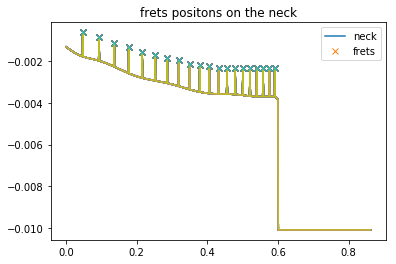

In [14]:
for name in names:
    campaign = remote_data[name]
    #if name.find('new') >=0 : 
    #    shift = 2
    #else:
    shift=1
    fileslist = {}
    results_path = remote_data["results_paths"][1]
    timers[name] = np.zeros((len(campaign), 3))
    print(results_path)
    j = 0
    for freq in campaign:
        fileslist[np.float(freq)] = os.path.join(results_path, campaign[freq][5])
        timers[name][j, :] = [np.float(freq), np.float(campaign[freq][1]), np.int(campaign[freq][2])]
        j += 1                   
    fileslist = collections.OrderedDict(sorted(fileslist.items()))
    #check_time_vectors(filelist, matlab_frets)
    errors[name], ymin[name], freqs[name], xref[name] = compute_errors(fileslist, dofs=dofs,
                                                                       savedofs=name + '_dofs.mat')#,ifref=-1)

### Plot convergence for bass guitar

In [15]:
for  name in errors:
    print(name)
    print(len(freqs[name]))
    print(errors[name].shape)
#bckp_err = dict(errors)
#errors.pop('one_contact_2018_1.0')
#for  name in errors:
#    print(name)
#    print(len(freqs[name]))
#    print(errors[name].shape)





bass_2018_0.0
14
(14, 2)
bass_2018_0.9
14
(14, 2)
bass_2018_1.0
14
(14, 2)


(15, 20)
(15, 20)
(15, 20)


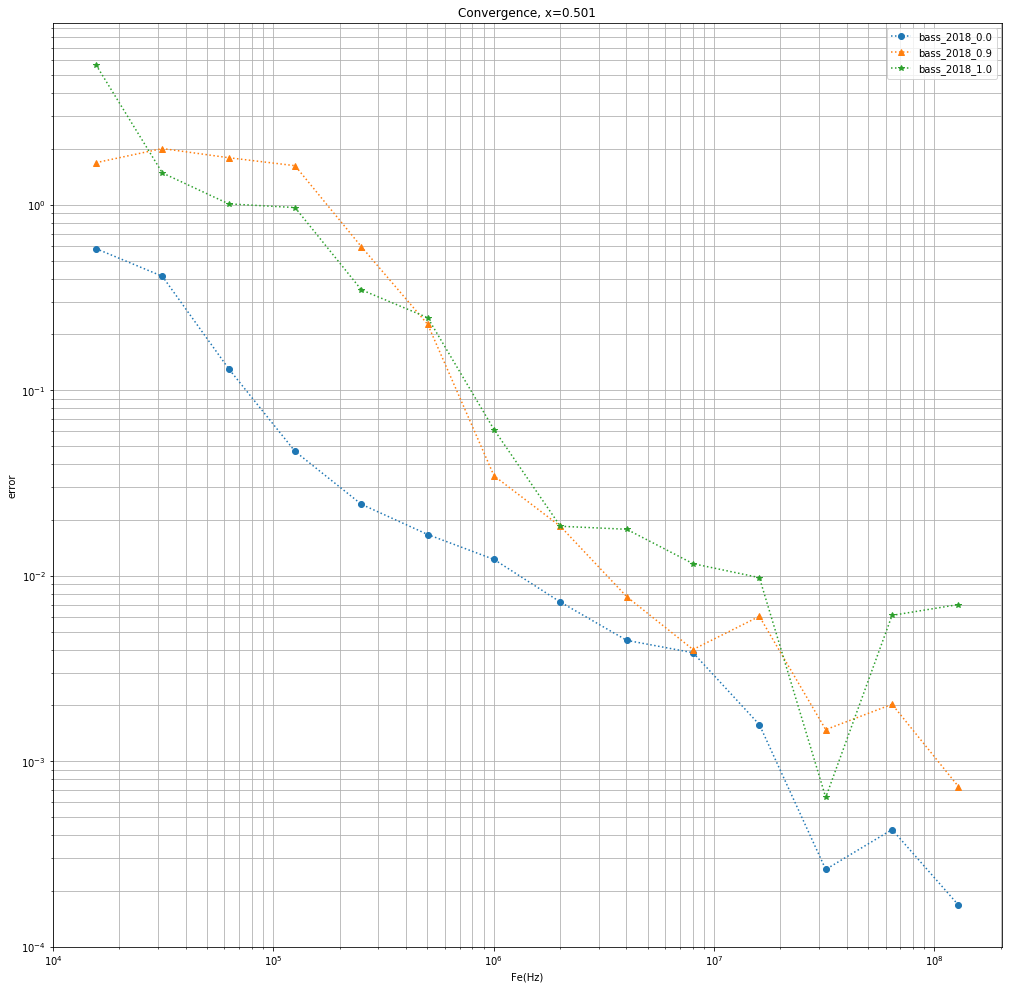

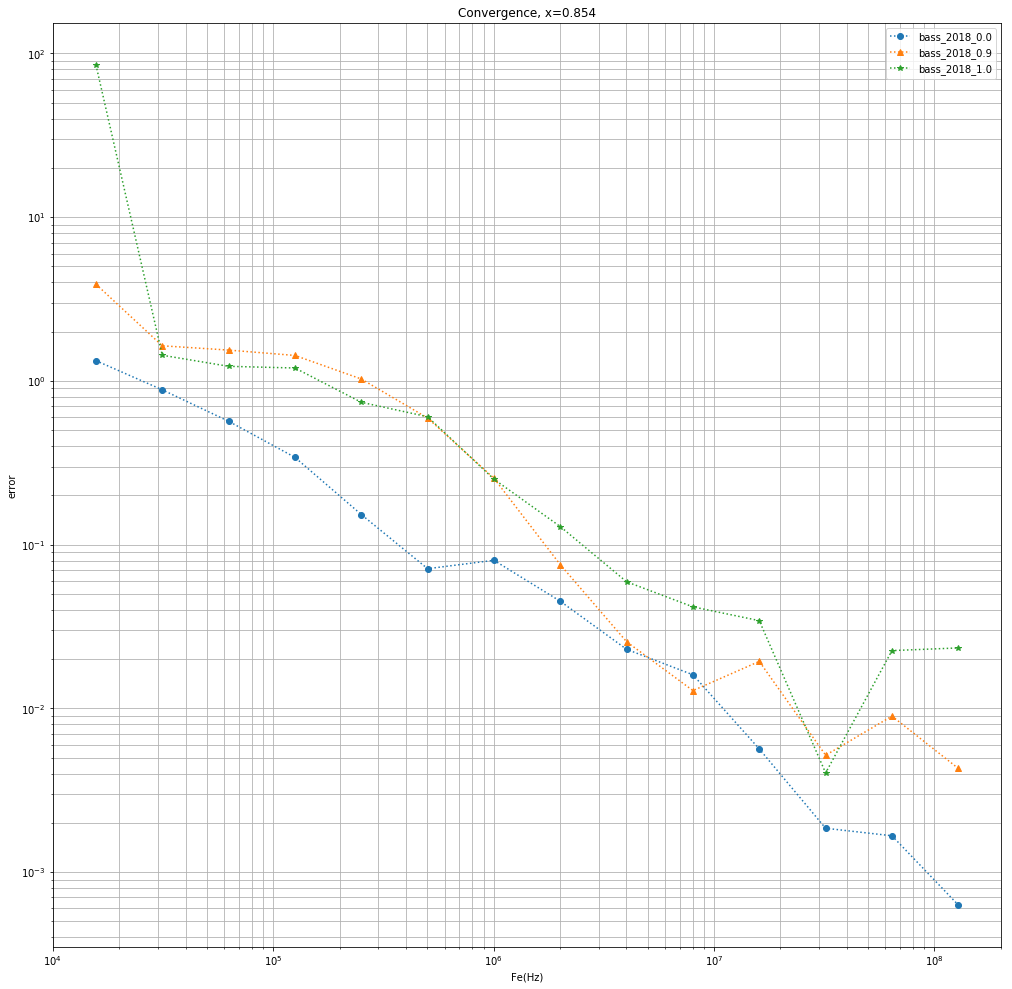

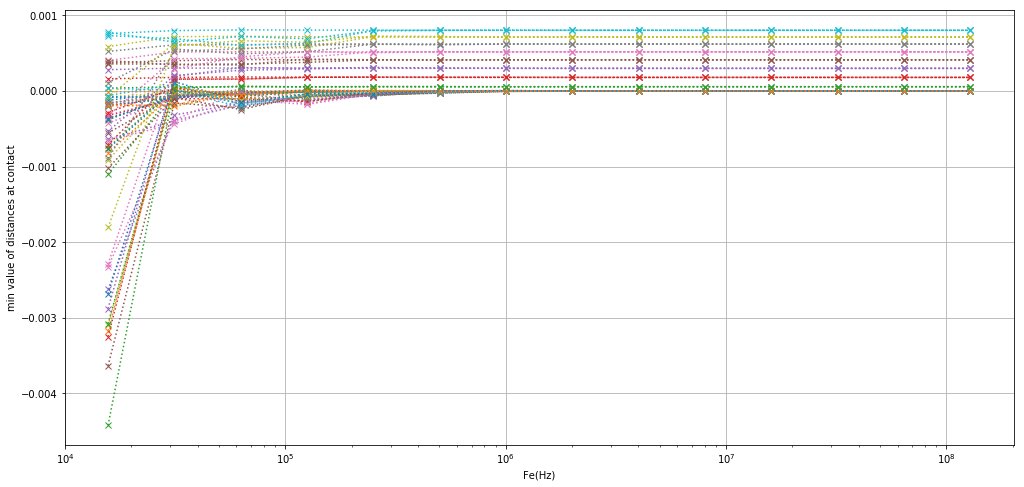

In [16]:
iplot = 388
for i in range(len(dofs)):
    fig = plot_errors(errors, freqs, i, xref, iplot, figures_path)
    iplot += 1

fig4 = plot_y(ymin, freqs, 4)
##fig4.title()
plt.savefig(os.path.join(figures_path, 'min_y.pdf'))

#### Save results (errors ...) in pkl file

date = datetime.datetime.now().isoformat()
bckpfilename = os.path.join(figures_path, 'backup' + str(date) + '.pkl')
print('backup to file ' + bckpfilename + ' ...')
bckpfile = open(bckpfilename, 'wb')
backups = (errors, ymin, freqs)
pickle.dump(backups, bckpfile)


# To load a file:
bckpfile = open('fig_campaign0212/backup2017-12-13T14:26:26.296423.pkl', 'rb')
#bckpfile = open('fig_campaign_new_0612/backup2017-12-14T11:16:22.928082.pkl', 'rb')

results = pickle.load(bckpfile)
err = results[0]
fre = results[2]
bckpfile.close()


for name in errors:
    err[name] = errors[name]
    fre[name] = freqs[name]

### plot simulations durations

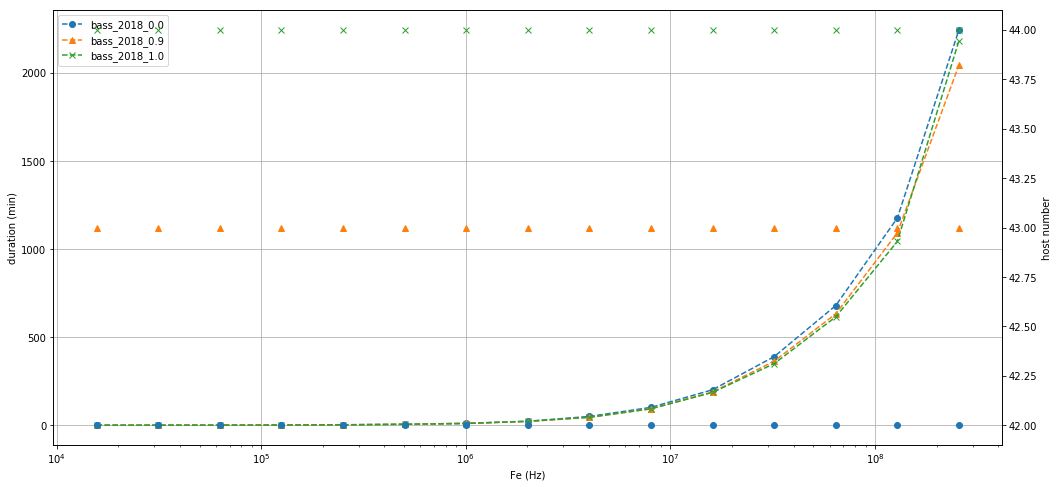

In [19]:
fig = plot_durations(timers)
plt.savefig(os.path.join(figures_path, 'Durations.pdf'))